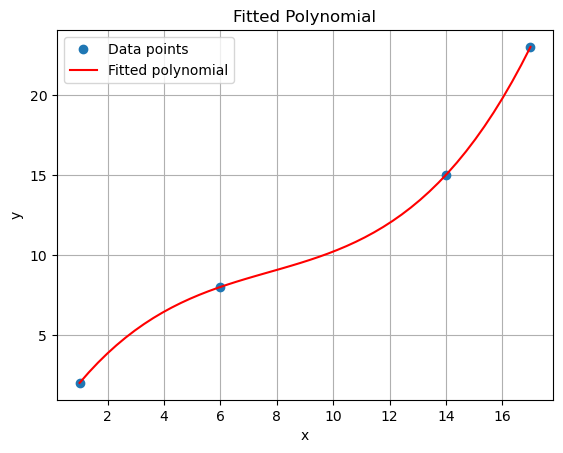

In [3]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt

x = np.array([1, 6, 14, 17])
y = np.array([2, 8, 15, 23])

n = len(x)
coefficients = np.polyfit(x, y, 3)
p = np.poly1d(coefficients)

x_values = np.linspace(min(x), max(x))

y_values = p(x_values)

plt.plot(x, y, 'o', label='Data points')
plt.plot(x_values, y_values, label='Fitted polynomial', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Polynomial')
plt.legend()
plt.grid(True)
plt.show()

4.49


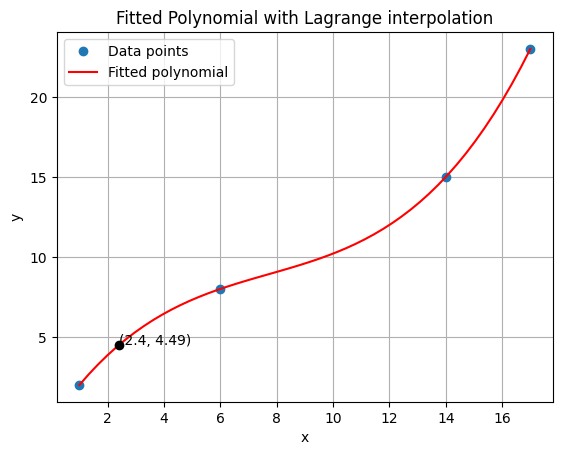

In [78]:
xp = 2.4

def evaluate(x, y, xp):
    yp = 0
    for i in range(n):
        p = 1
        for j in range(n):
            if i != j:
                p = p * (xp - x[j]) / (x[i] - x[j])
        yp = yp + y[i] * p
    return yp

yp = evaluate(x, y, xp)
yp = round(yp, 2)
print(yp)

plt.plot(x, y, 'o', label='Data points')
plt.plot(x_values, y_values, label='Fitted polynomial', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Polynomial with Lagrange interpolation')
plt.legend()
plt.grid(True)

plt.plot(xp, yp, 'ko', label='Point (xp, yp)')
plt.text(xp, yp, f'({xp}, {yp})', ha='left')

plt.show()

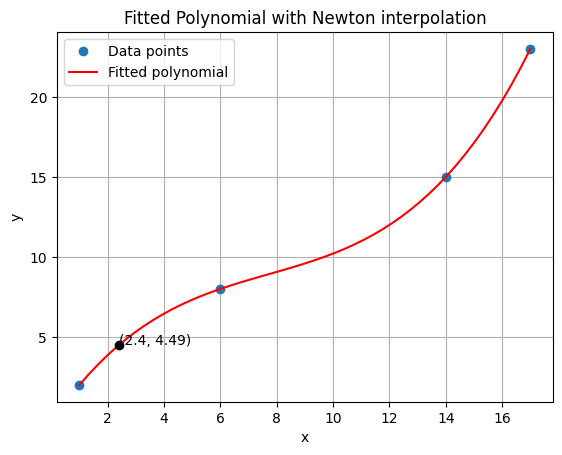

In [79]:
xp = 2.4

def newton_coefficients(x, y):
    f = np.zeros((n, n))

    # construct the divided difference table
    for i in range(n):
        f[i, 0] = y[i]
    for j in range(1, n):
        for i in range(n - j):
            f[i, j] = (f[i+1, j-1] - f[i, j-1]) / (x[i+j] - x[i])   
    # print(f)
  
    coefficients = np.zeros(n)
    for i in range(0, n):
        coefficients[i] = f[0, i]
    return coefficients

def evaluate(x, y, xp):
    coefficients = newton_coefficients(x, y)
    n = len(coefficients)
    yp = coefficients[0]
    for i in range(1, n):
        term = coefficients[i]
        for j in range(i):
            term *= (xp - x[j])
        yp += term
    return yp

yp = evaluate(x, y, xp)
yp = round(yp, 2)

plt.plot(x, y, 'o', label='Data points')
plt.plot(x_values, y_values, label='Fitted polynomial', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Polynomial with Newton interpolation')
plt.legend()
plt.grid(True)

plt.plot(xp, yp, 'ko', label='Point (xp, yp)')
plt.text(xp, yp, f'({xp}, {yp})', ha='left')

plt.show()

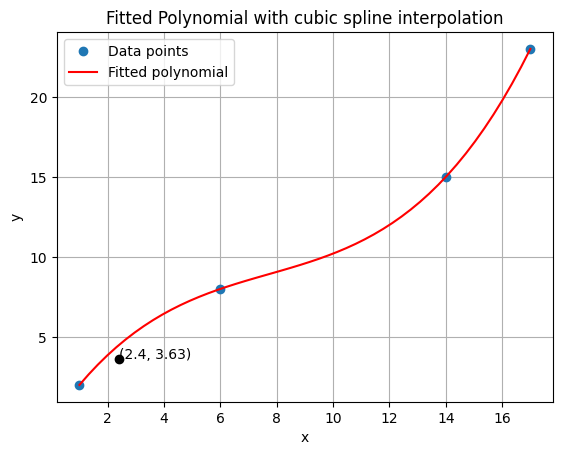

In [80]:
xp = 2.4

def find_interval(x, xp):
    # Find the index i such that x[i] <= xp < x[i+1]
    for i in range(len(x) - 1):
        if x[i-1] <= xp < x[i]:
            return i
    return None  # If xp is outside the range

def evaluate_cubic_spline(x, y, h, z, xp, i):
    # Evaluate the cubic spline at xp for the interval i
    C = (y[i] - y[i-1] + h**2 * (z[i-1]-z[i]) / 6) / h
    D = y[i-1] - h**2 * z[i-1] / 6
    result = z[i-1]*(x[i]-xp)**3 / (6*h) + z[i]*(xp-x[i-1])**3 / (6*h) + C*(xp-x[i-1]) + D
    return result

def tridiagonal_solver(a, b, c, d):
    n = len(d)
    w = np.zeros(n-1,float)
    g = np.zeros(n, float)
    p = np.zeros(n,float)
    
    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p
    
def cubic_spline_interpolation(x, y, xp):
    # Given n+1 points
    n = len(x) - 1

    index = find_interval(x, xp)
    h = x[index] - x[index-1]
    
    z = np.zeros(n+1)
    z[0] = z[n] = 0 # Calculating natural cubic spline

    alpha = np.zeros(n)
    beta = np.zeros(n)
    b = np.zeros(n)
    
    b[1] = (y[2] - 2*y[1] + y[0])/h - h*z[0]/6
    b[n-1] = (y[n] - 2*y[n-1] + y[n-2])/h - h*z[n]/6 

    for i in range (1, n):
        alpha[i] = 2*h/3
        beta[i] = h/6
        if (i >= 2 and i < n-1):
            b[i] = (y[i+1] - 2*y[i] + y[i-1])/h

    z[1:-1] = tridiagonal_solver(beta[1:-1], alpha[1:], beta[1:-1], b[1:]) 
    
    return evaluate_cubic_spline(x, y, h, z, xp, index)
    
    
yp = cubic_spline_interpolation(x, y, xp)
yp = round(yp, 2)

plt.plot(x, y, 'o', label='Data points')
plt.plot(x_values, y_values, label='Fitted polynomial', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Polynomial with cubic spline interpolation')
plt.legend()
plt.grid(True)

plt.plot(xp, yp, 'ko', label='Point (xp, yp)')
plt.text(xp, yp, f'({xp}, {yp})', ha='left')

plt.show()

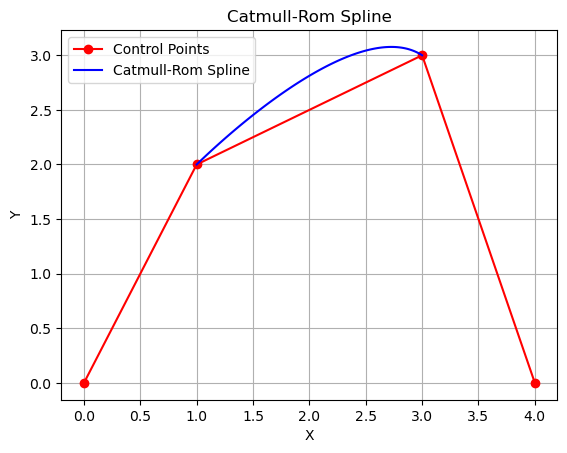

In [5]:
# Reference: https://qroph.github.io/2018/07/30/smooth-paths-using-catmull-rom-splines.html

def catmull_rom_spline(P0, P1, P2, P3, n_points=100):
    t = np.linspace(0, 1, n_points)
    t2 = t**2
    t3 = t**3
    
    b0 = 0.5 * (-t3 + 2*t2 - t)
    b1 = 0.5 * (3*t3 - 5*t2 + 2)
    b2 = 0.5 * (-3*t3 + 4*t2 + t)
    b3 = 0.5 * (t3 - t2)
    
    x = b0*P0[0] + b1*P1[0] + b2*P2[0] + b3*P3[0]
    y = b0*P0[1] + b1*P1[1] + b2*P2[1] + b3*P3[1]
    
    return x, y

control_points = np.array([
    [0, 0],
    [1, 2],
    [3, 3],
    [4, 0],
])

spline_points_x = []
spline_points_y = []
P0 = control_points[0]
P1 = control_points[1]
P2 = control_points[2]
P3 = control_points[3]
x, y = catmull_rom_spline(P0, P1, P2, P3)

plt.plot(control_points[:, 0], control_points[:, 1], 'ro-', label='Control Points')
plt.plot(x, y, 'b-', label='Catmull-Rom Spline')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Catmull-Rom Spline')
plt.grid(True)
plt.show()

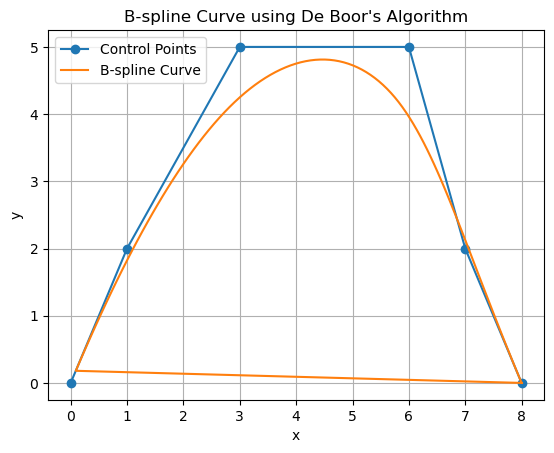

In [79]:
def de_boor(k, x, t, c, p):
    d = [c[j + p - k] for j in range(0, k + 1)]
    for r in range(1, k + 1):
        for j in range(k, r - 1, -1):
            alpha = (x - t[j + p - k]) / (t[j + 1 + p - r] - t[j + p - k])
            d[j] = (1.0 - alpha) * d[j - 1] + alpha * d[j]
    return d[k]

control_points = np.array([[0, 0], [1, 2], [3, 5], [6, 5], [7, 2], [8, 0]])

k = 3

n = len(control_points)
knots = np.concatenate(([0]*k, np.linspace(0, 1, n - k + 1), [1]*k))

t_values = np.linspace(knots[k], knots[-k-1], 100)
spline_points = np.array([de_boor(k, t, knots, control_points, np.searchsorted(knots, t) - 1) for t in t_values])

plt.plot(control_points[:, 0], control_points[:, 1], 'o-', label='Control Points')
plt.plot(spline_points[:, 0], spline_points[:, 1], label='B-spline Curve')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('B-spline Curve using De Boor\'s Algorithm')
plt.grid(True)
plt.show()
